#Data Processes second assignment (second part)

####CAMPILLO MORALES Salvador
####HUC-LHUILLERY Alexia
####GONG Seong-Min
####TRIBOUT Antoine

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFdr
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import time
from imblearn.over_sampling import SMOTEN
from sympy import symbols, Eq, solve
import scipy.stats as st
from scipy.stats import norm




In [ ]:
## MANUAL FUNCTIONS

# This function will be use to categorize the BMI variable
def transformBMI(x):
    if x <= 18.5:
        return 1
    elif 18.5 < x <= 25:
        return 2
    elif 25 < x <= 30:
        return 3
    elif 30 < x <= 35:
        return 4
    elif 35 < x <= 40:
        return 5
    elif x > 40:
        return 6
    else:
        return 0

# This function will be use to rearrange ranges in PhysHlth and MentHlth  
def transformHlth(x):
    if x <= 5:
        return 1
    elif 6 < x <= 10:
        return 2
    elif 11 < x <= 15:
        return 3
    elif 16 < x <= 20:
        return 4
    elif 21 < x <= 25:
        return 5
    elif 26 < x <= 30:
        return 6
    else:
        return 0



In [ ]:
## PART 1 - FILE READING, PRELIMINAR ANALYSIS AND TYPE TRANSFORMATIONS

# Data loading
df = pd.read_csv("/heart_disease.csv")
display(df)
# Check the shape 
print(df.shape)

# Ensure that there are not null values. 
print(df.isnull().sum())

# Analyze variable types and look for the portion of cases with a previous history of hearth attack. The prevalence of that is ~10% 
print(df.dtypes)
print("The global prevalence of hearth attack cases in the provided sample is: "+str(round(df.HeartDiseaseorAttack.sum() / df.shape[0]*100,2))+"%")

# Check whether if there are some wrong values for the binary variables or not. All binary variables seem to be properly encoded.
print("Values present in binary variables: "+str((df['Fruits'].append(df['Veggies']).append(df['HeartDiseaseorAttack']).append(df['HighBP']).append(df['HighChol'])
.append(df['CholCheck']).append(df['Smoker']).append(df['Stroke']).append(df['PhysActivity']).append(df['HvyAlcoholConsump'])
.append(df['DiffWalk']).append(df['Sex'])).unique()))

# Convert all binary variables (currently encoded as numerical) to categorical ones.
df["Fruits"]=pd.get_dummies(df["Fruits"])[1].astype('category')
df["Veggies"]=pd.get_dummies(df["Veggies"])[1].astype('category')
df["HeartDiseaseorAttack"]=pd.get_dummies(df["HeartDiseaseorAttack"])[1].astype('category')
df["HighBP"]=pd.get_dummies(df["HighBP"])[1].astype('category')
df["HighChol"]=pd.get_dummies(df["HighChol"])[1].astype('category')
df["CholCheck"]=pd.get_dummies(df["CholCheck"])[1].astype('category')
df["Smoker"]=pd.get_dummies(df["Smoker"])[1].astype('category')
df["Stroke"]=pd.get_dummies(df["Stroke"])[1].astype('category')
df["PhysActivity"]=pd.get_dummies(df["PhysActivity"])[1].astype('category')
df["HvyAlcoholConsump"]=pd.get_dummies(df["HvyAlcoholConsump"])[1].astype('category')
df["Sex"]=pd.get_dummies(df["Sex"])[1].astype('category')
df["DiffWalk"]=pd.get_dummies(df["DiffWalk"])[1].astype('category')

# Analyze multi-level categorical variables.
print("Values present in diabetes variable: "+str((df['Diabetes'].unique())))
print("Values present in general health variable: "+str((df['GenHlth'].unique())))
print("Values present in mental health variable: "+str((df['MentHlth'].unique())))
print("Values present in physical health variable: "+str((df['PhysHlth'].unique())))
print("Values present in education variable: "+str((df['Education'].unique())))
print("Values present in income variable: "+str((df['Income'].unique())))

# MenthHlth and PhysHlth are going to be rearranged using five levels, as happens with 'GenHlth'. 
# each level will be defined at the following way
# Level 1: 1 to 5 points
# Level 2: 6 to 10 points
# Level 3: 11 to 15 points
# Level 4: 16 to 20 points
# Level 5: 21 to 25 points
# Level 6:26 to 30 points
df["PhysHlth"]= df["PhysHlth"].apply(lambda x: transformHlth(x)).astype('category')
df["MentHlth"]= df["MentHlth"].apply(lambda x: transformHlth(x)).astype('category')

# Encode the categorical variables as that, converting types.
df["Diabetes"]=df["Diabetes"].astype('uint8').astype('category')
df["GenHlth"]=df["GenHlth"].astype('uint8').astype('category')
df["Education"]=df["Education"].astype('uint8').astype('category')
df["Income"]=df["Income"].astype('uint8').astype('category')

# Analyze the numerical variables
print(df["BMI"].describe())
print(df["Age"].describe())

# Values taken by Age seem to be too low (min=1;max=13). This fact suggests that age is actually a categorical variable (where each possible
# value represents a range of ages rather than a single one). Some insighs about the nature of this variable and its relationship  with others 
# reinforce this hypothesis. For example, there are much more occurrences regarding the values supposedly associated with higher ages than occurrences
# regarding the values supposedly associated with lower ages (coherent with high median age populations), and the incidence of hearth attacks is clearly higher
# in the first case than in the second. For for all this, "age" is going to be considered as a categorical variable.
print(df["Age"].value_counts())
print("The incidence of heart attacks for patients having one of the four lowest age values is: " + 
      str(round((df.loc[df['HeartDiseaseorAttack'] == 1]["Age"].value_counts()[1]+df.loc[df['HeartDiseaseorAttack'] == 1]["Age"].value_counts()[2]+
       df.loc[df['HeartDiseaseorAttack'] == 1]["Age"].value_counts()[3]+df.loc[df['HeartDiseaseorAttack'] == 1]["Age"].value_counts()[4])/
       (df["Age"].value_counts()[1]+df["Age"].value_counts()[2]+df["Age"].value_counts()[3]+df["Age"].value_counts()[4])*100,2))+"%")
print("The incidence of heart attacks for patients having one of the four higher age values is: " + 
      str(round((df.loc[df['HeartDiseaseorAttack'] == 1]["Age"].value_counts()[10]+df.loc[df['HeartDiseaseorAttack'] == 1]["Age"].value_counts()[11]+
       df.loc[df['HeartDiseaseorAttack'] == 1]["Age"].value_counts()[12]+df.loc[df['HeartDiseaseorAttack'] == 1]["Age"].value_counts()[13])/
       (df["Age"].value_counts()[10]+df["Age"].value_counts()[11]+df["Age"].value_counts()[12]+df["Age"].value_counts()[13])*100,2))+"%")

# Encode age as categorical variable.
df["Age"]=df["Age"].astype('uint8').astype('category')

# Like the other variables, "BMI" will be categorized. For that, the most usual BMI classification will be used.
# - Underweight (1): BMI ≤ 18.5
# - Normal weight (2): 18.5 < BMI ≤ 25
# - Overweight (3): 18.5 < BMI ≤ 30
# - Obesity I (4): 30 < BMI ≤ 35
# - Obesity II (5): 35 < BMI ≤ 40
# - Obesity III (6): 40 < BMI
df["BMI"]= df["BMI"].apply(lambda x: transformBMI(x)).astype('category')

#display(df)

# Finally, take a copy of the dataset and encode all variables as numeric ones. A Label Encoding approach will be choosen
# instead of an One Hot Encoding, due to the fact that a numeric order makes sense in the context of these explanatory variables. 
df_num=df.copy()
columns=df.columns
for column in columns:
    df_num[column]=df_num[column].astype("int32")
#print(df_num.dtypes)

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,0.0,1.0,1.0,1.0,18.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


(253680, 20)
HeartDiseaseorAttack    0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
Diabetes                0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64
HeartDiseaseorAttack    float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
Diabetes                float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
GenHlth                 float64
MentHlth                float64
PhysHl

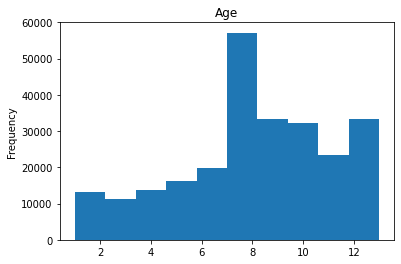

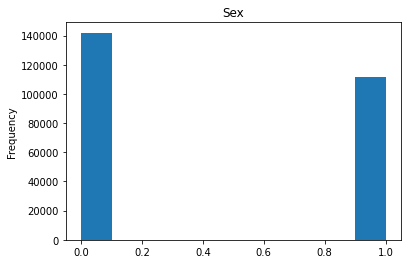

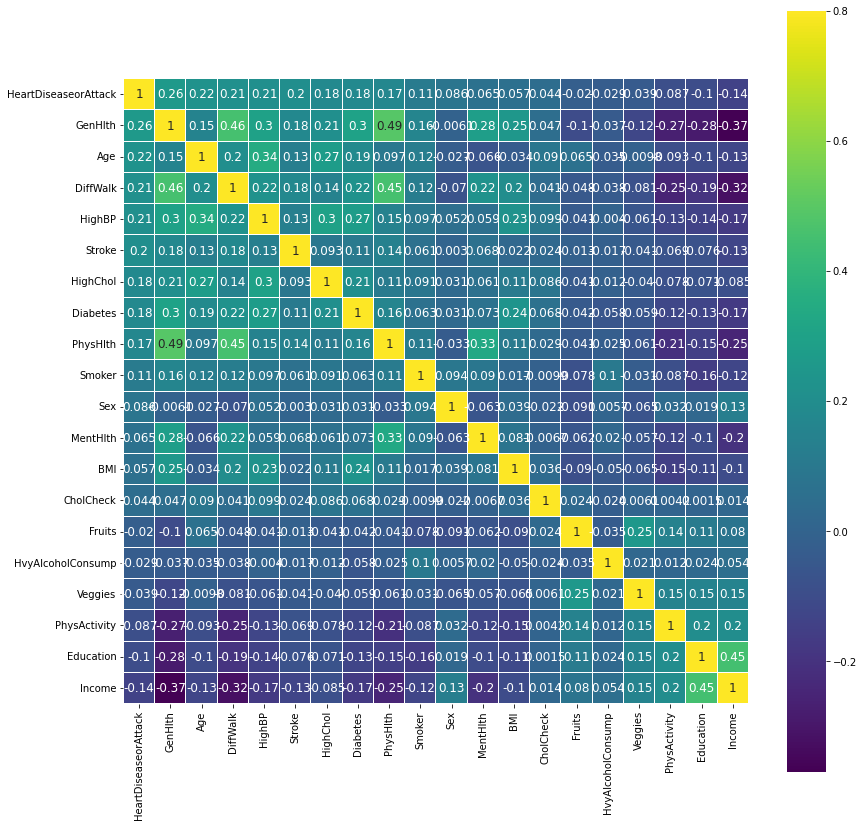

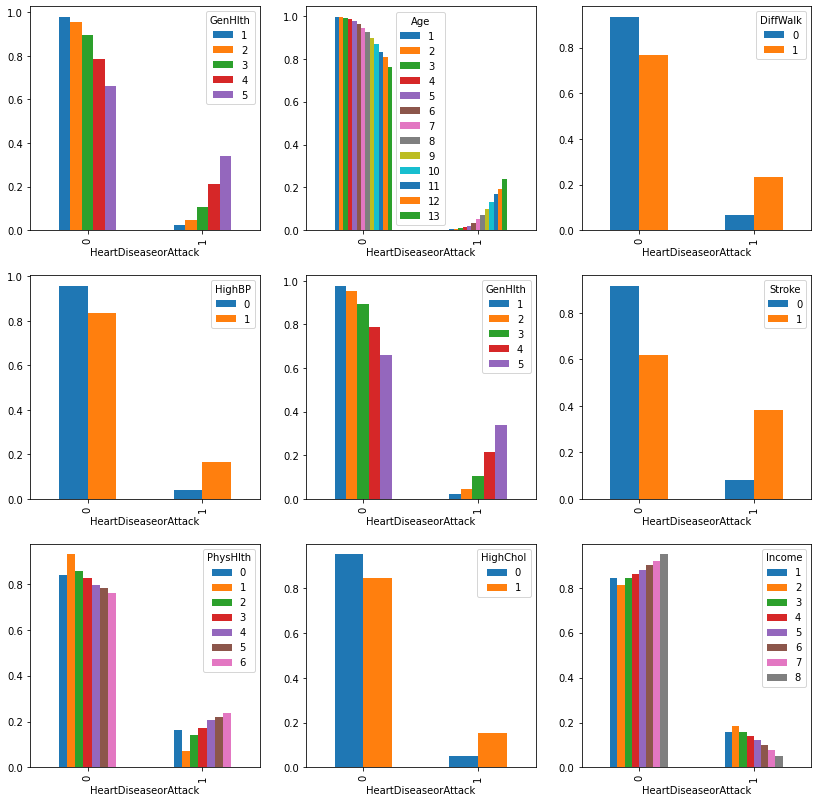

<ipython-input-4-3d39877ccd4d>:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrapper['HeartDiseaseorAttack']=df['HeartDiseaseorAttack']


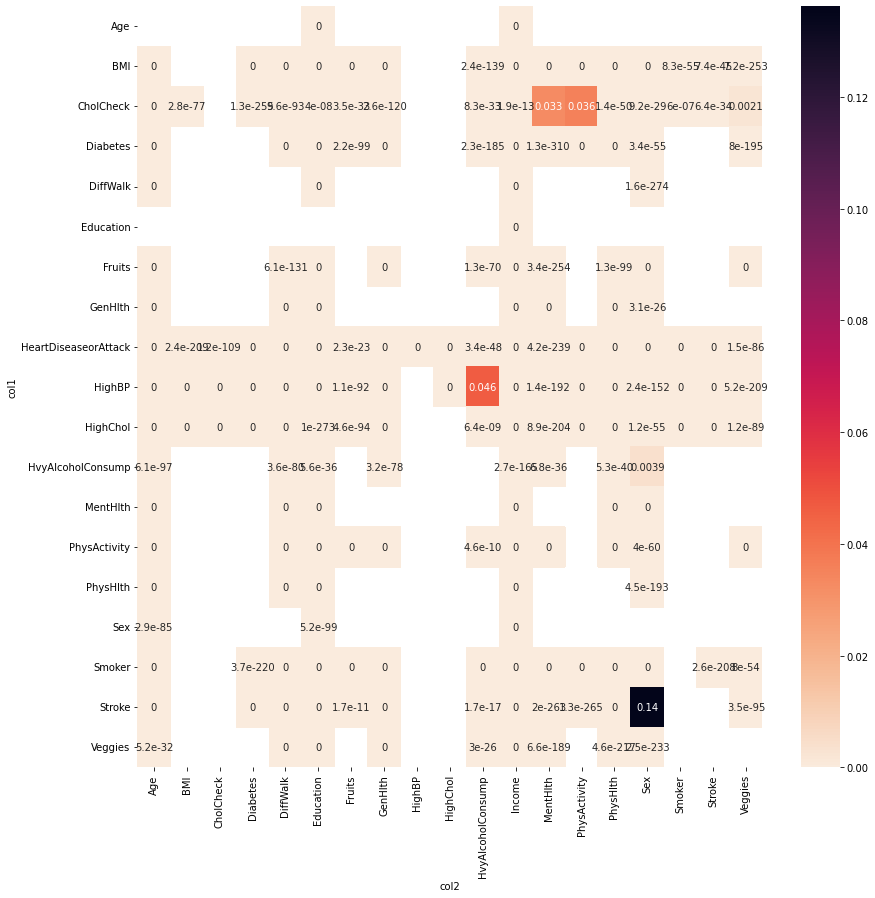

In [ ]:
## PART 2 - SOME EXPLORATORY DATA ANALYSIS AND FEATURE SUBSET SELECTION

## EXPLORATORY ANALYSIS

# Sample histograms on sex and age. Results suggest that the sample looks quite alike
# the global population of a developed country, at least in what concerns demographic issues.
# Age
df_num["Age"].plot.hist()
plt.title("Age")
plt.show()
#Sex
df_num["Sex"].plot.hist()
plt.title("Sex")
plt.show()
# A correlation map can provide a first useful insigth about correlation patterns in the dataset (among 
# explanatory variables as well as among the response variable and each of the explanatory variables). 
# The numeric version of the dataset will be used for that task. 
correlation = df_num.corr()
k= df.shape[1]
cols = correlation.nlargest(k,'HeartDiseaseorAttack')['HeartDiseaseorAttack'].index
f, ax = plt.subplots(figsize = (14,14))
sns.heatmap(np.corrcoef(df[cols].values.T), vmax=.8, linewidths=0.01,square=True,annot=True,cmap='viridis',
           linecolor="white",xticklabels = cols.values ,annot_kws = {'size':12},yticklabels = cols.values)

# Represent relative values for the different levels for the categorical variables with higher |r| values, 
# stratified by the response variable. A strong visual hint about high correlations with the response variable 
# is provided here
fig, ax = plt.subplots(3, 3, figsize=(14, 14))
# GenHealth
dt = pd.crosstab(df['HeartDiseaseorAttack'],df['GenHlth'],margins=True)
dt = dt.apply(lambda x : x/(float (x.loc['All'])), axis=0).drop('All',axis=1)
dt.drop('All').plot(kind='bar', ax=ax[0, 0])
# Age
dt = pd.crosstab(df['HeartDiseaseorAttack'],df['Age'],margins=True)
dt = dt.apply(lambda x : x/(float (x.loc['All'])), axis=0).drop('All',axis=1)
dt.drop('All').plot(kind='bar', ax=ax[0, 1])
# DiffWalk
dt = pd.crosstab(df['HeartDiseaseorAttack'],df['DiffWalk'],margins=True)
dt = dt.apply(lambda x : x/(float (x.loc['All'])), axis=0).drop('All',axis=1)
dt.drop('All').plot(kind='bar', ax=ax[0, 2])
# HighBP
dt = pd.crosstab(df['HeartDiseaseorAttack'],df['HighBP'],margins=True)
dt = dt.apply(lambda x : x/(float (x.loc['All'])), axis=0).drop('All',axis=1)
dt.drop('All').plot(kind='bar', ax=ax[1, 0])
# GenHealth
dt = pd.crosstab(df['HeartDiseaseorAttack'],df['GenHlth'],margins=True)
dt = dt.apply(lambda x : x/(float (x.loc['All'])), axis=0).drop('All',axis=1)
dt.drop('All').plot(kind='bar', ax=ax[1, 1])
# Stroke
dt = pd.crosstab(df['HeartDiseaseorAttack'],df['Stroke'],margins=True)
dt = dt.apply(lambda x : x/(float (x.loc['All'])), axis=0).drop('All',axis=1)
dt.drop('All').plot(kind='bar', ax=ax[1, 2])
# PhysHlth
dt = pd.crosstab(df['HeartDiseaseorAttack'],df['PhysHlth'],margins=True)
dt = dt.apply(lambda x : x/(float (x.loc['All'])), axis=0).drop('All',axis=1)
dt.drop('All').plot(kind='bar', ax=ax[2, 0])
# HighChol
dt = pd.crosstab(df['HeartDiseaseorAttack'],df['HighChol'],margins=True)
dt = dt.apply(lambda x : x/(float (x.loc['All'])), axis=0).drop('All',axis=1)
dt.drop('All').plot(kind='bar', ax=ax[2, 1])
# Income
dt = pd.crosstab(df['HeartDiseaseorAttack'],df['Income'],margins=True)
dt = dt.apply(lambda x : x/(float (x.loc['All'])), axis=0).drop('All',axis=1)
dt.drop('All').plot(kind='bar', ax=ax[2, 2])
plt.show()

# Perform a chisquare test over each pair of variables in the dataset and represent the results in a 
# heatmap. As can be observed, all explanatory variables seem to have a statistically significant re-
# lationship with the response variable, as well as among them. That suggests the possibility of be 
# dealing with a certain level of redundant information. 
columns=df.columns
p_values = []
for i, col1 in enumerate(columns):
    for col2 in columns[i+1:]:
        chi2, p, _, _ = chi2_contingency(pd.crosstab(df[col1], df[col2]))
        p_values.append((col1, col2, p))
p_values_df = pd.DataFrame(p_values, columns=['col1', 'col2', 'p_value'])
pivot_table = p_values_df.pivot(index='col1', columns='col2', values='p_value')
plt.figure(figsize=(14,14))
sns.heatmap(pivot_table, cmap=sns.color_palette("rocket_r", as_cmap=True),annot=True)
#print(p_values)

## FEATURE SELECTION

# As all p-values regarding combinations of a explanatory variable and the response 
# variable are smaller than 0.05 (in fact by a wide margin), that threeshold can't be 
# used to filter any dataframe column. Instead of that, what can be done is using the
# mutual information between explanatory variables and the target as criterion for selecting variables. 
# Half of the columns (the ones with better scores) will be selected.
fs_k_best = SelectPercentile(score_func=mutual_info_classif,percentile=50)
fs_k_best=fs_k_best.fit(df.drop('HeartDiseaseorAttack', axis=1), df.HeartDiseaseorAttack)
col_filter = fs_k_best.get_support()
df_k_best = df.drop("HeartDiseaseorAttack", axis=1).iloc[:, col_filter]
df_k_best["HeartDiseaseorAttack"]=df.HeartDiseaseorAttack

# In addition, a wrapper subset selector will be implemented over the original dataset, in order
# to get an additional reduced version. A forward (start from null, populate then) method will
# be used, employing GaussianNB as the algorithm for finding the best possible subset. The reason for
# selecting a NB algorithm is that Naive Bayes is particularly sensitive to redundant information. 
X = df.loc[:, df.columns != 'HeartDiseaseorAttack']
y = df['HeartDiseaseorAttack']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)
scv = StratifiedKFold(n_splits=5)
sfs = SequentialFeatureSelector(GaussianNB(),
                 direction='forward',
                 scoring='f1_macro',
                 cv=5,
                 n_jobs=-1)
sfs = sfs.fit(X, y)
selected_columns = df.drop('HeartDiseaseorAttack', axis=1).columns[sfs.get_support()]
df_wrapper = df[selected_columns]
df_wrapper['HeartDiseaseorAttack']=df['HeartDiseaseorAttack']

#display(df_k_best)
#display(df_wrapper)
#print(df_k_best.dtypes)
#print(df_wrapper.dtypes)





In [ ]:
# PART 3 - BUILDING MACHINE LEARNING MODELS ON THE DATASETS


# Creation and evaluation of machine learning models to predict the people
# with a heart diseas or attack 
# We use classifier algorithms to compute the models, because we want to predict 
# the classes 1 or 0 for the column HeartDiseaseorAttack
# The three datasets are used, the full one, the one with the 10th best predictors,
# and the one reduced by a wrapper subset selector
# We compute 5 models for each, k-nearest neighbord, decision tree, multi-layer 
# perceptron, random forest and gradient boosting
# We compute a cross-validation score to get the accuracy of the model, and
# a confusion matrix on a test data set for each one to compare them 
# We also print the time spend on computation for each model 

datasets = [df,df_k_best, df_wrapper] 
donnees = ["Models with the original dataset","Models with univariate filter FSS based on mutual information",
           "Models with forward wrapper FSS based on GaussianNB"] 
i=0

for d in datasets:
    y = d['HeartDiseaseorAttack']
    x = d.drop('HeartDiseaseorAttack', axis=1)
    
    x_train, x_valid, y_train, y_valid = train_test_split(x, y,
                                                          train_size=0.7, test_size=0.3,
                                                          random_state=0)
    print("\n ********** \n", donnees[i], "\n ********** \n")
    i += 1

    tps1 = time.time()
    randf = RandomForestClassifier(n_jobs=-1, random_state=0, class_weight='balanced')
    randf.fit(x_train, y_train)
    pred = randf.predict(x_valid)
    scores = cross_val_score(randf, x, y, cv=4)
    tps2 = time.time()
    print("\nRandom Forest classifier : \n")
    print("%0.2f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
    tn, fp, fn, tp = confusion_matrix(y_valid, pred).ravel()
    print("Selectivity: %0.2f" % (tn / (tn + fp)))     
    print("Recall: %0.2f" % (recall_score(y_valid, pred)))
    print("AUC area: %0.2f" % roc_auc_score(y_valid, pred))
    print('confusion matrix: ')
    print(confusion_matrix(y_valid, pred))
    print("\nExecution time : ", tps2-tps1)
    
    tps1 = time.time()
    tree = DecisionTreeClassifier(random_state=0, class_weight='balanced')
    tree.fit(x_train, y_train)
    pred = tree.predict(x_valid)
    scores = cross_val_score(tree, x, y, cv=4)
    tps2 = time.time()
    print("\nDecision Tree classifier : \n")
    print("%0.2f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
    tn, fp, fn, tp = confusion_matrix(y_valid, pred).ravel()
    print("Selectivity: %0.2f" % (tn / (tn + fp)))     
    print("Recall: %0.2f" % (recall_score(y_valid, pred)))
    print("AUC area: %0.2f" % roc_auc_score(y_valid, pred))
    print('confusion matrix: ')
    print(confusion_matrix(y_valid, pred))
    print("\nExecution time : ", tps2-tps1)
    
    oversample = SMOTEN(k_neighbors=25)
    x_train, y_train = oversample.fit_resample(x_train, y_train)
    
    tps1 = time.time()
    knclass = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
    knclass.fit(x_train, y_train)
    pred = knclass.predict(x_valid)
    scores = cross_val_score(knclass, x, y, cv=4)
    tps2 = time.time()
    print("\nK-nearest Neighbors classifier : \n")
    print("%0.2f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
    tn, fp, fn, tp = confusion_matrix(y_valid, pred).ravel()
    print("Selectivity: %0.2f" % (tn / (tn + fp)))     
    print("Recall: %0.2f" % (recall_score(y_valid, pred)))
    print("AUC area: %0.2f" % roc_auc_score(y_valid, pred))
    print('confusion matrix: ')
    print(confusion_matrix(y_valid, pred))
    print("\nExecution time : ", tps2-tps1)
    
    tps1 = time.time()
    gdc = GradientBoostingClassifier(random_state=0)
    gdc.fit(x_train, y_train)
    pred = gdc.predict(x_valid)
    scores = cross_val_score(gdc, x, y, cv=4)
    tps2 = time.time()
    print("\nGradient Boosting classifier : \n")
    print("%0.2f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
    tn, fp, fn, tp = confusion_matrix(y_valid, pred).ravel()
    print("Selectivity: %0.2f" % (tn / (tn + fp)))     
    print("Recall: %0.2f" % (recall_score(y_valid, pred)))
    print("AUC area: %0.2f" % roc_auc_score(y_valid, pred))
    print('confusion matrix: ')
    print(confusion_matrix(y_valid, pred))
    print("\nExecution time : ", tps2-tps1)
    
    tps1 = time.time()
    clf = MLPClassifier(learning_rate='adaptive', learning_rate_init=0.01, random_state=0)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_valid)
    scores = cross_val_score(clf, x, y, cv=4)
    tps2 = time.time()
    print("\nMulti-layer Perceptron classifier : \n")
    print("%0.2f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
    tn, fp, fn, tp = confusion_matrix(y_valid, pred).ravel()
    print("Selectivity: %0.2f" % (tn / (tn + fp)))     
    print("Recall: %0.2f" % (recall_score(y_valid, pred)))
    print("AUC area: %0.2f" % roc_auc_score(y_valid, pred))
    print('confusion matrix: ')
    print(confusion_matrix(y_valid, pred))
    print("\nExecution time : ", tps2-tps1)

    tps1 = time.time()
    nb = GaussianNB()
    nb.fit(x_train, y_train)
    pred = nb.predict(x_valid)
    scores = cross_val_score(nb, x, y, cv=4)
    tps2 = time.time()
    print("\nGaussian Naive Bayes Classifier : \n")
    print("%0.2f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
    tn, fp, fn, tp = confusion_matrix(y_valid, pred).ravel()
    print("Selectivity: %0.2f" % (tn / (tn + fp)))     
    print("Recall: %0.2f" % (recall_score(y_valid, pred)))
    print("AUC area: %0.2f" % roc_auc_score(y_valid, pred))
    print('confusion matrix: ')
    print(confusion_matrix(y_valid, pred))
    print("\nExecution time : ", tps2-tps1)


 ********** 
 Models with the original dataset 
 ********** 


Random Forest classifier : 

0.89 accuracy with a standard deviation of 0.000
Selectivity: 0.96
Recall: 0.15
AUC area: 0.55
confusion matrix: 
[[66332  2508]
 [ 6201  1063]]

Execution time :  16.645469427108765

Decision Tree classifier : 

0.84 accuracy with a standard deviation of 0.002
Selectivity: 0.90
Recall: 0.28
AUC area: 0.59
confusion matrix: 
[[61813  7027]
 [ 5251  2013]]

Execution time :  4.227090358734131

K-nearest Neighbors classifier : 

0.89 accuracy with a standard deviation of 0.001
Selectivity: 0.93
Recall: 0.26
AUC area: 0.60
confusion matrix: 
[[64133  4707]
 [ 5360  1904]]

Execution time :  1193.7543103694916

Gradient Boosting classifier : 

0.91 accuracy with a standard deviation of 0.000
Selectivity: 0.81
Recall: 0.58
AUC area: 0.69
confusion matrix: 
[[55648 13192]
 [ 3081  4183]]

Execution time :  96.59149932861328

Multi-layer Perceptron classifier : 

0.91 accuracy with a standard deviatio

In [ ]:
## PART 4 - MINIMUM ADHERENCE COMPUTING
#First, we are going to compute the confidence intervals for "HeartDiseaseorAttack" in the original sample.
proportion = df["HeartDiseaseorAttack"].astype("int32").mean()
a=st.t.interval (alpha = 0.95, df = len (df) -1, loc =proportion, scale = st.sem (df))
print(f"The lower bound for a 95% confidence interval regarding heart attack prevalence is: {round(a[0].mean()*100,2)}%")
print(f"The upper bound for a 95% confidence interval regarding heart attack prevalence is: {round(a[1].mean()*100,2)}%")

# We are going to compute this using the results for two different models.

# Premise 1: A sample of 100k patients:
#   -Lower bound: 9100 patients that are highly prone to suffer a heart attack
#   -Upper bound: 9730 patients that are highly prone to suffer a heart attack

# Premise 2: Partitions are homogeneous. For example, if 85% of the patients classified as prone to suffer
# a heart attack follows the treatment, we're going to suppose that the percentage of initial adherence to the
# treatment is the same both for patients correctly and incorrectly classified. We could compute confidence 
# intervals for that percentages but this simple method can provide us a sort of central value for minimum 
# required final adherence

# Premise 3: If a patient adheres a treatment at the beginning and then quits it before its end, the cost of
# the treatment is 1000€, as occurs with patients that follow the treatment till the end

# MODEL 1: Gaussian Naive Bayes with mutual information
# Although the wrapper model provides a higher accuracy (what is coherent with the fact that GaussianNB was
# the method used for the wrapper), the recall in that case is particularly high (which is a capital issue in
# that case, due to the importance of avoiding false negatives in that case, both for economic and public health
# reasons).

# Selectivity: 0.58 ; recall: 0.87 ; AUC: 0,72

# Projected confussion matrix (lower bound)
# [[52722 38178]
#  [1183  7917]]
# Projected confussion matrix (upper bound)
# [[52357 37913]
#  [1265  8465]]

# Total cost (original, lower bound): 9100*50000 = 455M€
# Total cost (original, upper bound): 9730*50000 = 486,5M€

# Minimum total cost for achieving the goal(lower bound) = 455*0,8 = 364M€
# Minimum total cost for achieving the goal(upper bound) = 486,5*0,8 = 389,2M€

# For the 1st scenario (lower bound):
# -> a ≡ adherence percentage ; b ≡ non-adherence percentage ; a + b = 1
# -> 1183 patients prone to suffer a hearth attack, wrongly classified = 59,15M€
# -> ~46095 patients adhering to treatment at the beginning = ~46,1M€
# -> ~1188 patients prone to suffer a hearth attack, reject treatment = ~59,4M€
# -> ~6729*b patients prone to suffer a heart attack not following it till the end = b*336,45M€
# -> ~6729*a patients prone to suffer a heart attack following it till the end, not avoiding h.a. = b*84,11M€

x, y = symbols('x y')
eq1 = Eq(x + y - 1)
eq2 = Eq(336450000*y + 84112500*x - 199405000)
sol_dict=solve((eq1,eq2), (x, y))
print(f'The minimum percentage of adherence required for achiving the proposed goal (Model 1, lower bound) is: {round(sol_dict[x]*100,2)}%')

# For the 2nd scenario (upper bound):
# -> a ≡ adherence percentage ; b ≡ non-adherence percentage ; a + b = 1
# -> 1265 patients prone to suffer a hearth attack, wrongly classified = 63,25M€
# -> ~46558 patients adhering to treatment at the beginning = ~46,1M€
# -> ~1269 patients prone to suffer a hearth attack, reject treatment = ~63,45M€
# -> ~7195*b patients prone to suffer a heart attack not following it till the end = b*359,75M€
# -> ~7195*a patients prone to suffer a heart attack following it till the end, not avoiding h.a. = b*89,94M€

x, y = symbols('x y')
eq1 = Eq(x + y - 1)
eq2 = Eq(359750000*y + 89937500*x - 215942000)
sol_dict=solve((eq1,eq2), (x, y))
print(f'The minimum percentage of adherence required for achiving the proposed goal (Model 1, upper bound) is: {round(sol_dict[x]*100,2)}%')


# MODEL 2: Multilayer Perceptron with wrapper forwarding FSS
# The recall for this second model is lower than the one for the first (0.81 vs. 0.87) but the selectivity is
# quite better (0.71 vs. 0.58). So we can expect this model to incurring in quite less false positives than the first
# with a little worse performance regarding false negatives. The AUC area for this model is the highest among all built
# models (0.76) so we can expect a good performance. 

# Selectivity: 0.71 ; recall: 0.81 ; AUC: 0,76

# Projected confussion matrix (lower bound)
# [[64539 26361]
#  [1729  7371]]
# Projected confussion matrix (upper bound)
# [[64092 26178
#  [1849  7881]]

# Total cost (original): 1000*50000 = 50M€
# Minimum total cost for achieving the goal = 50*0,8 = 40M€
# For the 1st scenario:
# -> a ≡ adherence percentage ; b ≡ non-adherence percentage ; a + b = 1
# -> 1729 patients prone to suffer a hearth attack, wrongly classified = 86,45M€
# -> 33732 patients adhering to treatment at the beginning = 33,73M€
# -> 1106 patients prone to suffer a hearth attack, reject treatment = 55,28M€
# -> ~6265*b patients prone to suffer a heart attack not following it till the end = b*313,27M€
# -> ~689*a patients prone to suffer a heart attack following it till the end, not avoiding h.a. = b*78,32M€

x, y = symbols('x y')
eq1 = Eq(x + y - 1)
eq2 = Eq(313267500*y + 78316875*x - 188518000)
sol_dict=solve((eq1,eq2), (x, y))
print(f'The minimum percentage of adherence required for achiving the proposed goal (Model 2, lower case) is: {round(sol_dict[x]*100,2)}%')

# Total cost (original): 1000*50000 = 50M€
# Minimum total cost for achieving the goal = 50*0,8 = 40M€
# For the 2nd scenario:
# -> a ≡ adherence percentage ; b ≡ non-adherence percentage ; a + b = 1
# -> 1849 patients prone to suffer a hearth attack, wrongly classified = 92,45M€
# -> 34059 patients adhering to treatment at the beginning = 34,01M€
# -> 1182 patients prone to suffer a hearth attack, reject treatment = 59,10M€
# -> ~6265*b patients prone to suffer a heart attack not following it till the end = b*334,94M€
# -> ~6265*a patients prone to suffer a heart attack following it till the end, not avoiding h.a. = b*83,74M€

x, y = symbols('x y')
eq1 = Eq(x + y - 1)
eq2 = Eq(334942500*y + 83735625*x - 203591000)
sol_dict=solve((eq1,eq2), (x, y))
print(f'The minimum percentage of adherence required for achiving the proposed goal (Model 2, upper case) is: {round(sol_dict[x]*100,2)}%')










    
    
    
    
    
    
  


The lower bound for a 95% confidence interval regarding heart attack prevalence is: 9.1%
The upper bound for a 95% confidence interval regarding heart attack prevalence is: 9.73%
The minimum percentage of adherence required for achiving the proposed goal (Model 1, lower bound) is: 54.31%
The minimum percentage of adherence required for achiving the proposed goal (Model 1, upper bound) is: 53.30%
The minimum percentage of adherence required for achiving the proposed goal (Model 2, lower case) is: 53.10%
The minimum percentage of adherence required for achiving the proposed goal (Model 2, upper case) is: 52.29%


/usr/local/lib/python3.8/dist-packages/sympy/core/relational.py:492: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
